# EventDisplay -- to display mPMT events in new npz file format

Edit to input the full geometry file, and npz data file that your are interested in.


Authors: Blair Jamieson, Connor Boubard


June 2020

In [1]:

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math

In [2]:

datafile = np.load('IWCDmPMT_4pi_full_tank_mu-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_25.npz',allow_pickle=True)
geofile = np.load('full_geo_dump.npz',allow_pickle=True)


# First let's explore the geometry file
Make sure we can find the phototube locations, and build a mapping from the three dimensional locations of the PMTs.

In [3]:
geofile.files

['tube_no', 'position', 'orientation']

In [4]:
tubes = geofile[ 'tube_no' ]
tubes

array([    1,     2,     3, ..., 15806, 15807, 15808])

In [10]:
tube_xyz = geofile[ 'position' ]
tube_x = tube_xyz[:,0]
tube_y = tube_xyz[:,1]
tube_z = tube_xyz[:,2]
R =  (tube_x.max() - tube_x.min())/2.0
print("R=",R)
print( "min_x=",tube_x.min(), "max_x=", tube_x.max(), "diameter=", tube_x.max() - tube_x.min() )
print( "min_z=",tube_z.min(), "max_z=", tube_z.max(), "diameter=", tube_z.max() - tube_z.min() )
print( "min_y=",tube_y.min(), "max_y=", tube_y.max(), "height=", tube_y.max() - tube_y.min() )

R= 370.0958251953125
min_x= -370.0958251953125 max_x= 370.0958251953125 diameter= 740.191650390625
min_z= -370.0958251953125 max_z= 370.0958251953125 diameter= 740.191650390625
min_y= -517.4490356445312 max_y= 517.4490356445312 height= 1034.8980712890625


In [6]:
tube_dir = geofile[ 'orientation']

array([[-7.99056649e-01, -5.87785244e-01, -1.26558140e-01],
       [-8.45031559e-01, -5.09036958e-01,  1.63716182e-01],
       [-8.78687561e-01, -2.93892622e-01,  3.76211733e-01],
       ...,
       [-1.54508501e-01, -9.51056540e-01, -2.67616570e-01],
       [ 1.54508501e-01, -9.51056540e-01, -2.67616570e-01],
       [ 0.00000000e+00, -1.00000000e+00,  6.12323426e-17]])

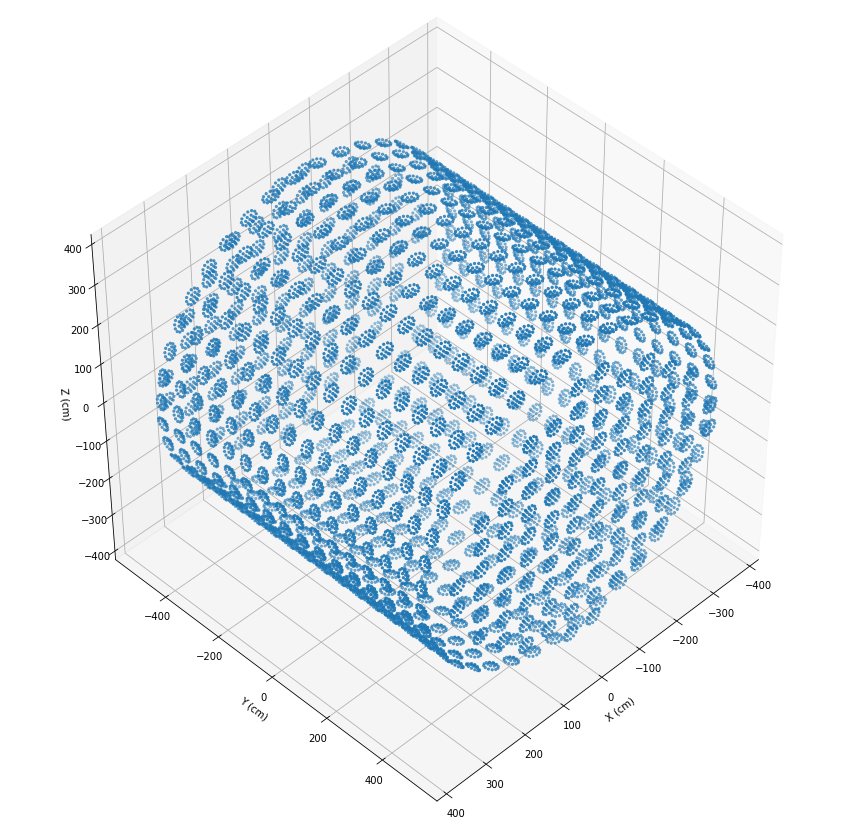

In [7]:

fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter( tube_x, tube_y, tube_z, marker='.'  )
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.view_init(elev=45.0, azim=45.0)
plt.show()


In [12]:


def PMT_to_flat_cylinder_mapping( tubes, tube_xyz ):
    """
    Build dictionary of PMT number, to (x,y) on a flat cylinder
    """
    mapping = {}
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y > 500. ):
            # in top circle of cylinder
            xflat = x
            yflat = 897.6 + z
            mapping[ int( tube ) ] = [ xflat, yflat ]
            
        elif ( y < -500.):
            # in bottom circle of cylinder
            xflat = x
            yflat = -897.6 + z
            mapping[ int( tube ) ] = [ xflat, yflat ]
            
        else:
            # in barrel part of cylinder
            theta = math.atan2( z, x )
            xflat = R * theta
            yflat = y
            mapping[ int( tube ) ] = [ xflat, yflat ]
    return mapping

PMTFlatMapping = PMT_to_flat_cylinder_mapping( tubes, tube_xyz )


In [46]:
def PMT_to_flat_cylinder_map_positive( tubes, tube_xyz ):
    """
    Build dictionary of PMT number, to (x,y) on a flat cylinder
    """
    mapping = {}
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y > 500. ):
            # in top circle of cylinder
            xflat = x+1162.7
            yflat = 2165.2 + z
            mapping[ int( tube ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        elif ( y < -500.):
            # in bottom circle of cylinder
            xflat = x+1162.7
            yflat = 370.1 + z
            mapping[ int( tube ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        else:
            # in barrel part of cylinder
            theta = math.atan2( z, x )
            xflat = R * theta + 1162.7
            yflat = y + 1267.7
            mapping[ int( tube ) ] = [ int(round(xflat)), int(round(yflat)) ]
    return mapping

PMTFlatMapPositive = PMT_to_flat_cylinder_map_positive( tubes, tube_xyz )

max0 = 0
max1 = 0
for pmt1 in PMTFlatMapPositive:
    if PMTFlatMapPositive[pmt1][0] < 0 or  PMTFlatMapPositive[pmt1][1] < 0 :
        print("PMT ",pmt1," at negative ",PMTFlatMapPositive[pmt1])
    if PMTFlatMapPositive[pmt1][0] > max0:
        max0 = PMTFlatMapPositive[pmt1][0]
    if PMTFlatMapPositive[pmt1][1] > max1:
        max1 = PMTFlatMapPositive[pmt1][1]
    for pmt2 in PMTFlatMapPositive:
        if pmt1 != pmt2:
            if PMTFlatMapPositive[pmt1] == PMTFlatMapPositive[pmt2]:
                print("PMT ",pmt1," and PMT ",pmt2," are both at ",PMTFlatMapPositive[pmt1])
            
print("max0=", max0, " max1=",max1)
PMTFlatMapPositive

max0= 2313  max1= 2502


{1: [1191, 1651],
 2: [1200, 1653],
 3: [1206, 1659],
 4: [1208, 1667],
 5: [1206, 1676],
 6: [1200, 1682],
 7: [1191, 1684],
 8: [1183, 1682],
 9: [1177, 1676],
 10: [1175, 1667],
 11: [1177, 1659],
 12: [1183, 1653],
 13: [1191, 1659],
 14: [1199, 1663],
 15: [1199, 1672],
 16: [1191, 1676],
 17: [1183, 1672],
 18: [1183, 1663],
 19: [1191, 1667],
 20: [1250, 1651],
 21: [1259, 1653],
 22: [1265, 1659],
 23: [1267, 1667],
 24: [1265, 1676],
 25: [1259, 1682],
 26: [1250, 1684],
 27: [1242, 1682],
 28: [1236, 1676],
 29: [1234, 1667],
 30: [1236, 1659],
 31: [1242, 1653],
 32: [1251, 1659],
 33: [1258, 1663],
 34: [1258, 1672],
 35: [1251, 1676],
 36: [1243, 1672],
 37: [1243, 1663],
 38: [1251, 1667],
 39: [1308, 1651],
 40: [1316, 1653],
 41: [1322, 1659],
 42: [1324, 1667],
 43: [1322, 1676],
 44: [1316, 1682],
 45: [1308, 1684],
 46: [1299, 1682],
 47: [1293, 1676],
 48: [1291, 1667],
 49: [1293, 1659],
 50: [1299, 1653],
 51: [1307, 1659],
 52: [1315, 1663],
 53: [1315, 1672],
 5

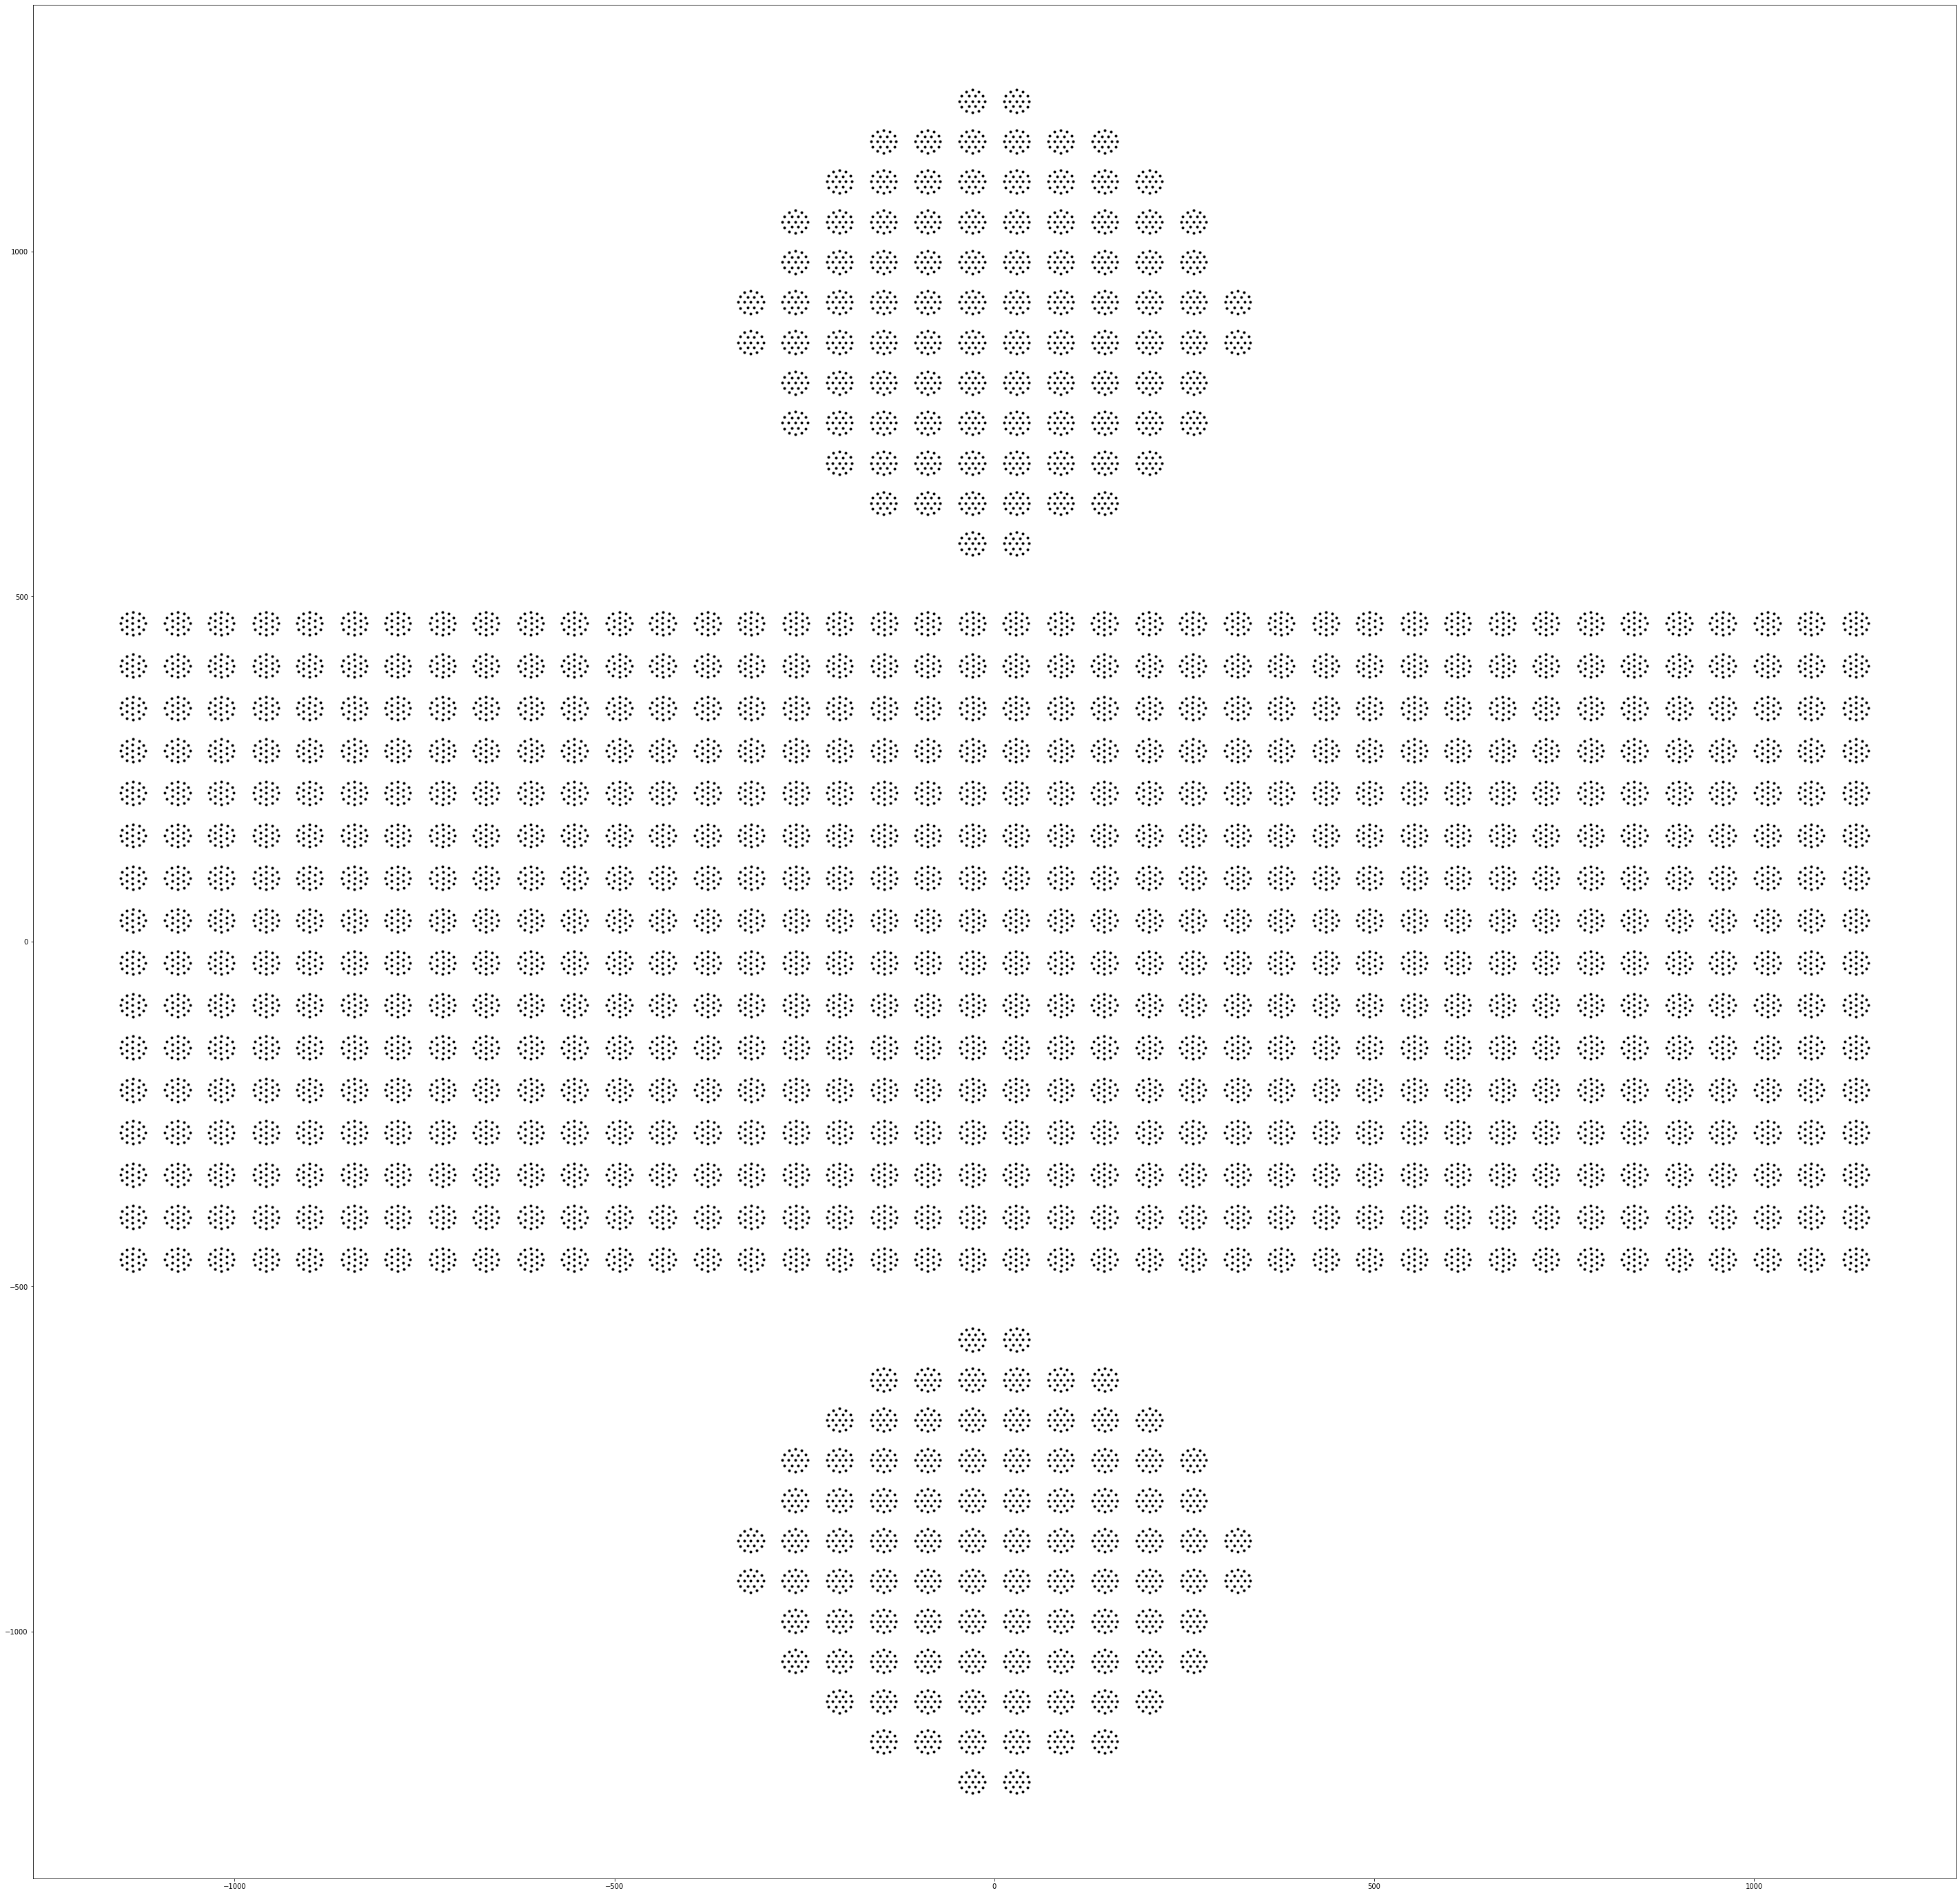

In [13]:
xflatvals = []
yflatvals = []
for tube in PMTFlatMapping:
    xflatvals.append( PMTFlatMapping[tube][0] )
    yflatvals.append( PMTFlatMapping[tube][1] )

fig = plt.figure(figsize=[50,50])    
plt.plot( xflatvals, yflatvals, '.', color='black' )
plt.savefig( 'mpmt_flatmap_positions.pdf')

Try making plot of PMT locations as image map

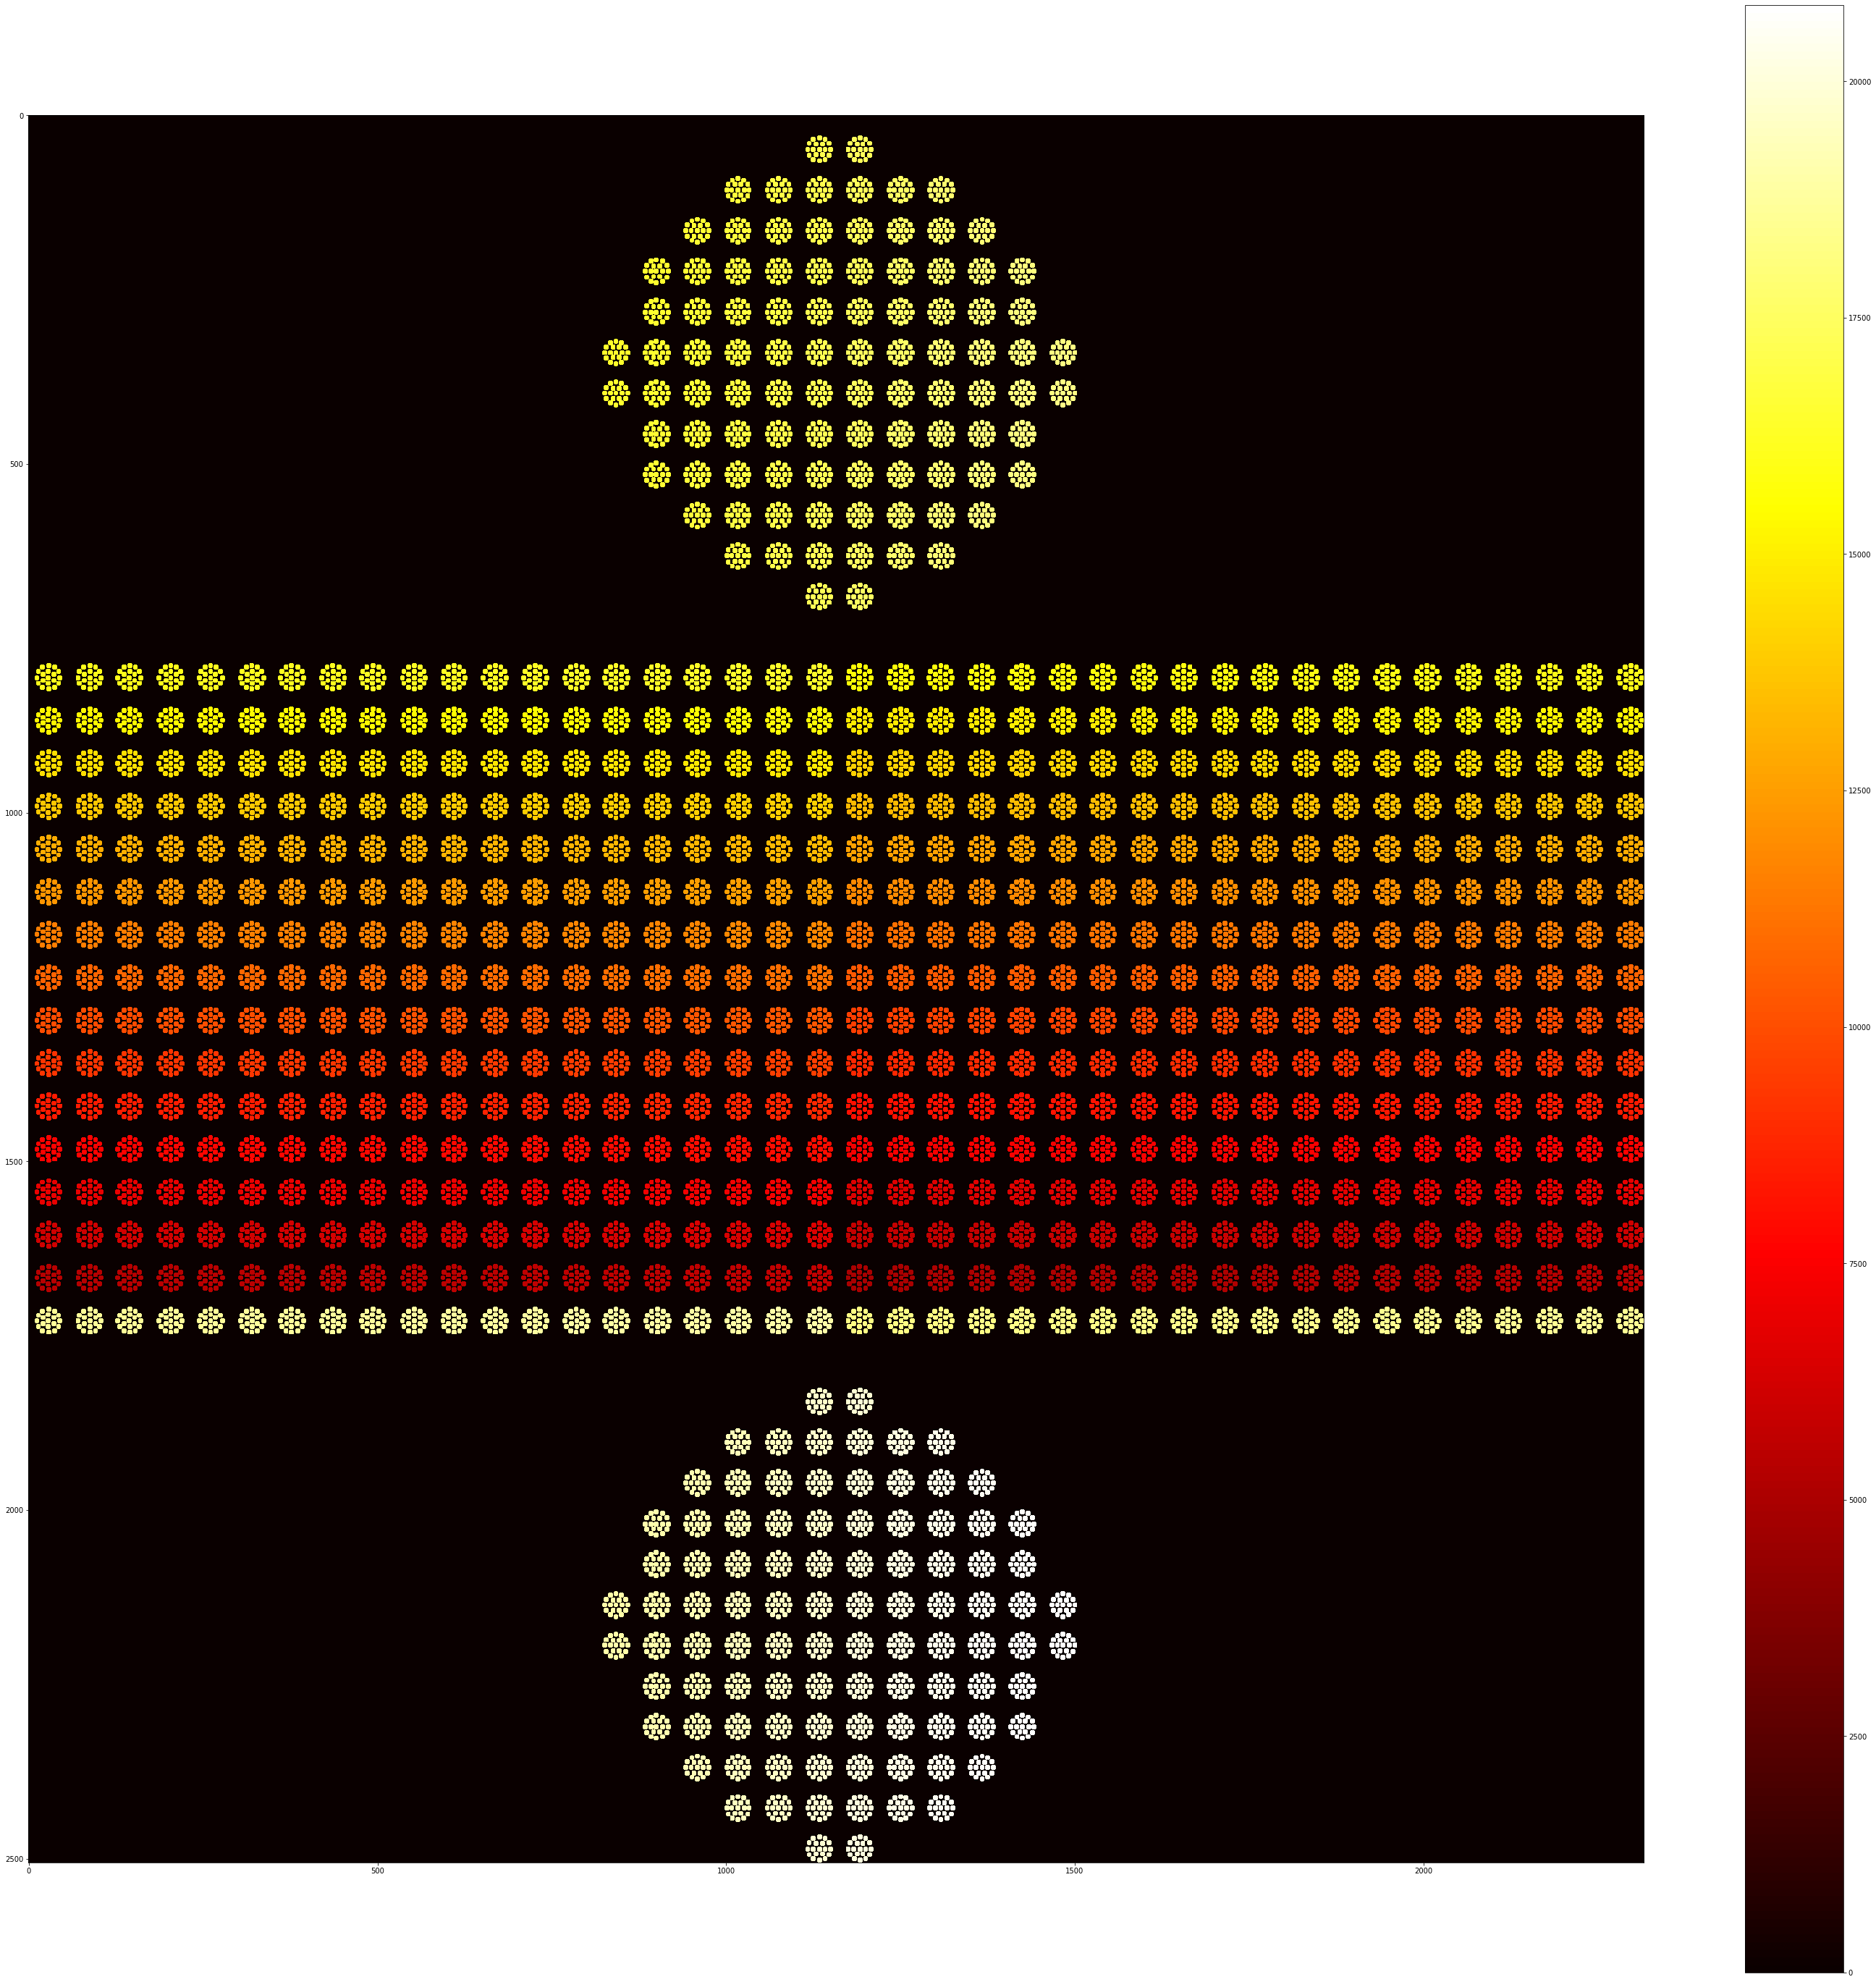

In [84]:
fig = plt.figure(figsize=[50,50]) 

preimage = np.zeros( [2506, 2317] )
maxtube = len(PMTFlatMapPositive)
for tube in PMTFlatMapPositive:
    for dx in range(-3,4):
        for dy in range(-3,4):
            if abs(dx)==3 and abs(dy)==3:
                continue
            preimage[ PMTFlatMapPositive[tube][1]+dx, PMTFlatMapPositive[tube][0]+dy ] = tube + 5000
plt.imshow( preimage )
#plt.set_cmap('Greys')
plt.set_cmap('hot')
plt.colorbar()
plt.savefig( 'mpmt_flatmap_positions_img.pdf',dpi=300)

# Now lets look at a few events

Need to explore contents of event data, and make presentations of that data.  Things to present are:

- Time of hits on each PMT
- Charge of hits on each PMT

In [56]:
datafile.files

['event_id',
 'root_file',
 'pid',
 'position',
 'direction',
 'energy',
 'digi_hit_pmt',
 'digi_hit_charge',
 'digi_hit_time',
 'digi_hit_trigger',
 'true_hit_pmt',
 'true_hit_time',
 'true_hit_pos',
 'true_hit_start_time',
 'true_hit_start_pos',
 'true_hit_parent',
 'track_id',
 'track_pid',
 'track_start_time',
 'track_energy',
 'track_start_position',
 'track_stop_position',
 'track_parent',
 'track_flag',
 'trigger_time']

In [63]:
evno = 0
digitubes = datafile[ 'digi_hit_pmt' ][ evno ]
digicharges = datafile[ 'digi_hit_charge' ][ evno ]
digitimes = datafile[ 'digi_hit_time' ][ evno ]

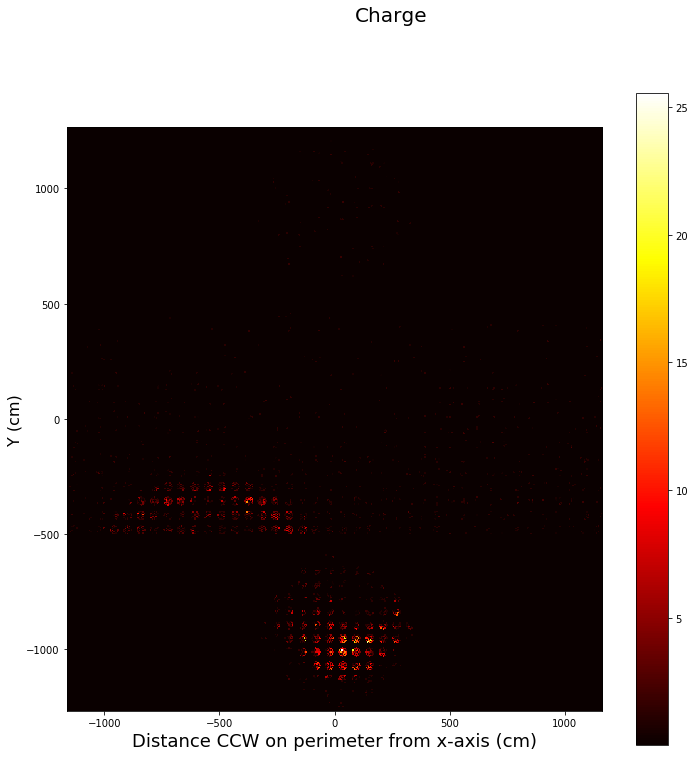

In [90]:
def EventDisplay( tubes, quantities, quantity_name="Charge", cutrange=[-1,-1] ):
    fig = plt.figure(figsize=[12,12]) 
    preimage = np.zeros( [2506, 2317] )
    imgmin = 10000
    imgmax = 0
    for idx, tube in enumerate( tubes ):
        if cutrange[0] != cutrange[1]:
            if quantities[idx] < cutrange[0] or quantities[idx] > cutrange[1]:
                continue
        if quantities[idx] > imgmax:
            imgmax = quantities[idx]
        if quantities[idx] < imgmin:
            imgmin = quantities[idx]
        for dx in range(-3,4):
            for dy in range(-3,4):
                if abs(dx)==3 and abs(dy)==3:
                    continue
                preimage[ PMTFlatMapPositive[tube][1]+dx, PMTFlatMapPositive[tube][0]+dy ] = quantities[idx]

    if cutrange[0] != cutrange[1]:
        imgmin = cutrange[0]
        imgmax = cutrange[1]
    plt.imshow( preimage, extent = [-1162.7,1162.7,-1267.7,1267.7], vmin=imgmin, vmax=imgmax )
    #plt.set_cmap('Greys')
    fig.suptitle(quantity_name, fontsize=20)
    plt.xlabel('Distance CCW on perimeter from x-axis (cm)', fontsize=18)
    plt.ylabel('Y (cm)', fontsize=16)
    plt.set_cmap('hot')
    plt.colorbar()
    
EventDisplay( digitubes, digicharges )
plt.savefig( 'event0_charge.pdf',dpi=300)

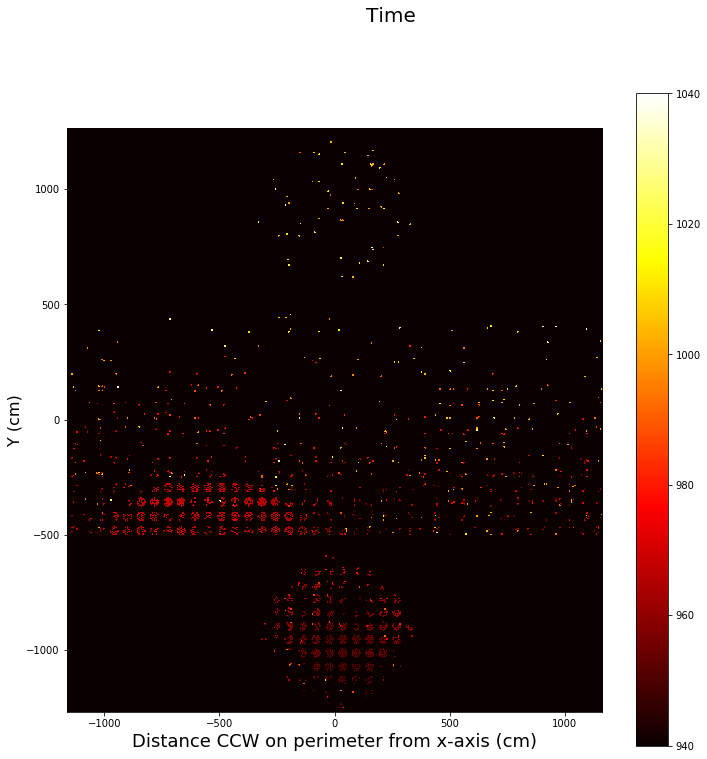

In [97]:
EventDisplay( digitubes, digitimes, "Time", [940, 1040] )
plt.savefig( 'event0_time.pdf',dpi=300)

# Make histograms of the charge and time distributions



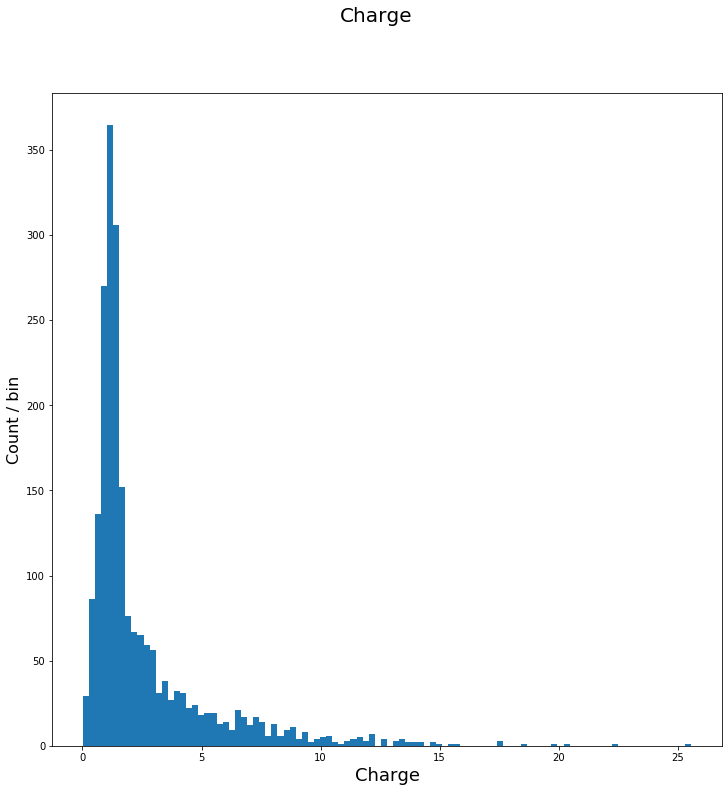

In [93]:
def EventDisplayHist( quantities, quantity_name="Charge", cutrange=[-1,-1] ):
    fig = plt.figure(figsize=[12,12]) 
    imgmin = 10000
    imgmax = 0
    for quantity in quantities:
        if quantity > imgmax:
            imgmax = quantity
        if quantity < imgmin:
            imgmin = quantity

    if cutrange[0] != cutrange[1]:
        imgmin = cutrange[0]
        imgmax = cutrange[1]
    plt.hist( quantities, 100, [imgmin, imgmax] )
    fig.suptitle(quantity_name, fontsize=20)
    plt.xlabel(quantity_name, fontsize=18)
    plt.ylabel('Count / bin', fontsize=16)

EventDisplayHist( digicharges, "Charge")

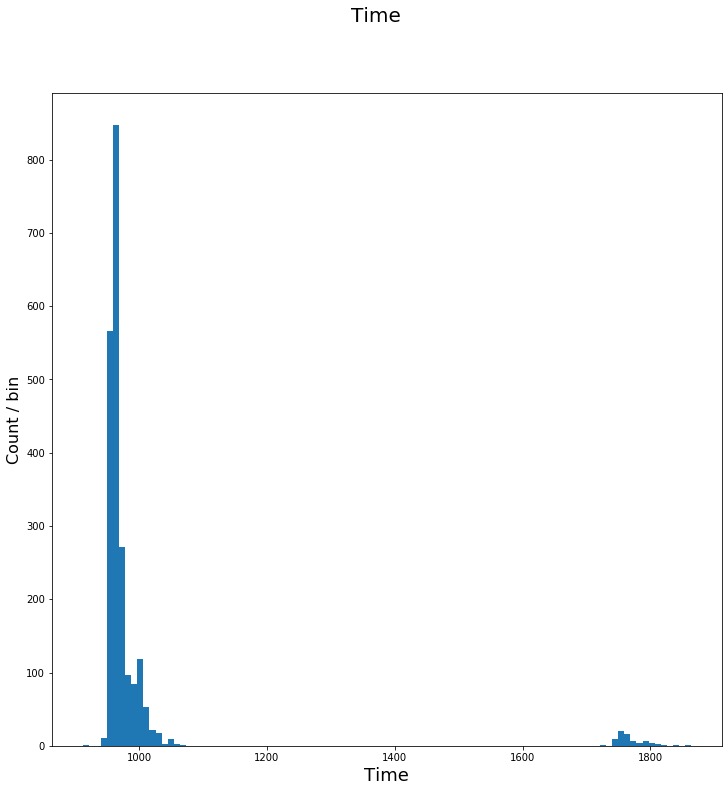

In [94]:
EventDisplayHist( digitimes, "Time")

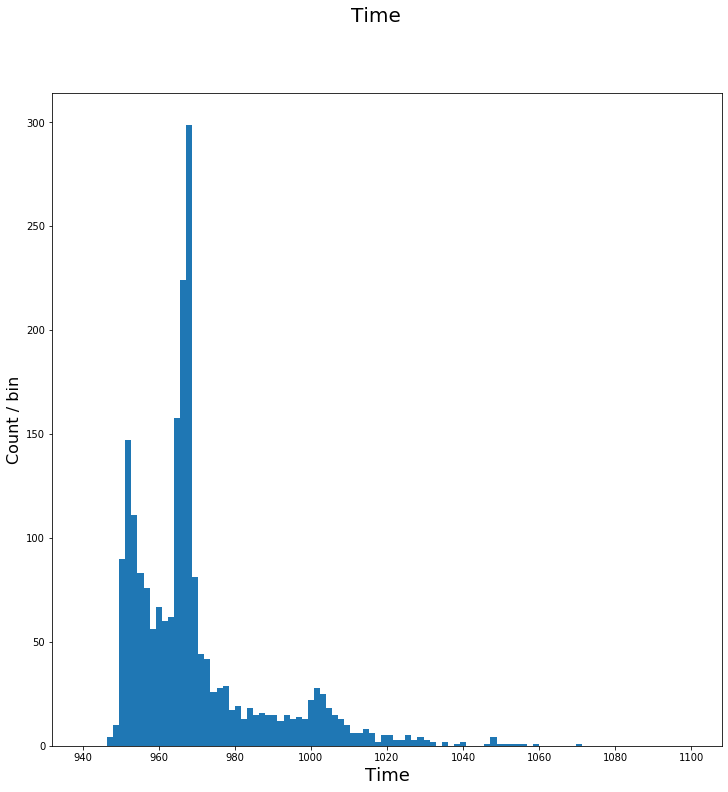

In [96]:
EventDisplayHist( digitimes, "Time", [940,1100])

In [ ]:
# Add a 2d histogram of charge versus time

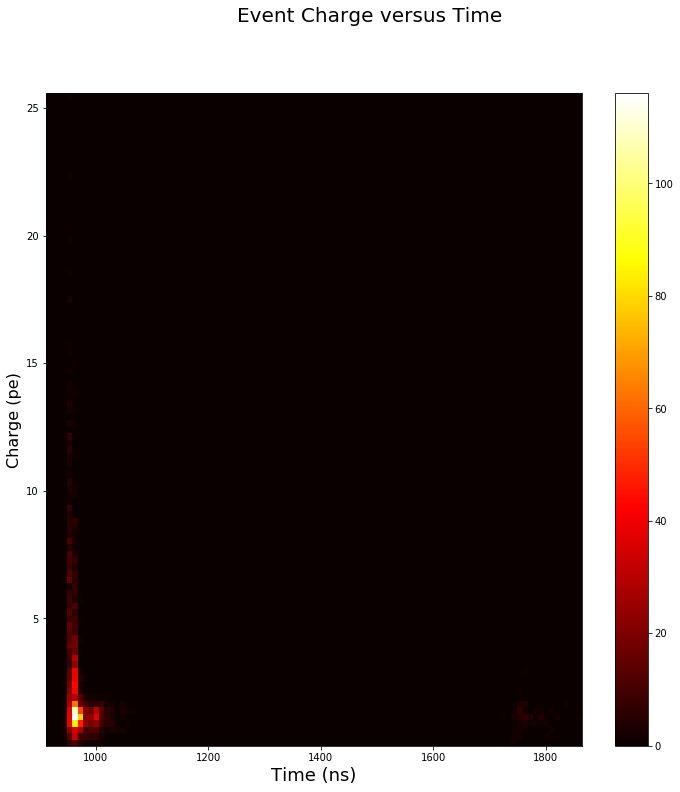

In [101]:
def ChargeTimeHist( times, charges, title='Event Charge versus Time', cutrange = [[-1,-1],[-1,-1]] ):
    fig = plt.figure(figsize=[12,12]) 
    tmin = 10000
    tmax = 0
    qmin = 10000
    qmax = 0

    for time in times:
        if time > tmax:
            tmax = time
        if time < tmin:
            tmin = time
    for q in charges:
        if q > qmax:
            qmax = q
        if q < qmin:
            qmin = q

    if cutrange[0][0] != cutrange[0][1]:
        tmin = cutrange[0][0]
        tmax = cutrange[0][1]
    if cutrange[1][0] != cutrange[1][1]:
        qmin = cutrange[1][0]
        qmax = cutrange[1][1]
        
    plt.hist2d( times, charges, [100,100], [[tmin,tmax],[qmin,qmax]] )
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Time (ns)', fontsize=18)
    plt.ylabel('Charge (pe)', fontsize=16)
    plt.set_cmap('hot')
    plt.colorbar()   
    
ChargeTimeHist( digitimes, digicharges )

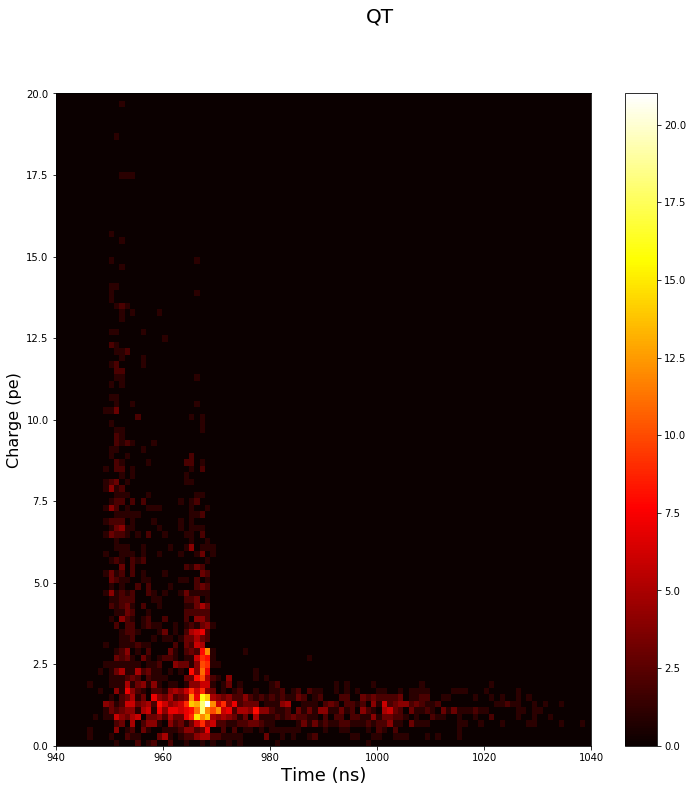

In [103]:
ChargeTimeHist( digitimes, digicharges, 'QT', [[940,1040],[0,20]] )